## Time series anomaly detection with Local Outlier Factor (LOF) and AWS EC2 CPU Utilization Data

In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

### Dataset - AWS EC2 CPU Utilization Data

In [2]:
df = pd.read_csv('ec2_cpu_utilization_24ae8d.csv')
df.head(10)

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134
5,2014-02-14 14:55:00,0.134
6,2014-02-14 15:00:00,0.134
7,2014-02-14 15:05:00,0.134
8,2014-02-14 15:10:00,0.066
9,2014-02-14 15:15:00,0.132


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  4032 non-null   object 
 1   value      4032 non-null   float64
dtypes: float64(1), object(1)
memory usage: 63.1+ KB


[Text(0.5, 0, 'Timestamp'), Text(0, 0.5, 'Value')]

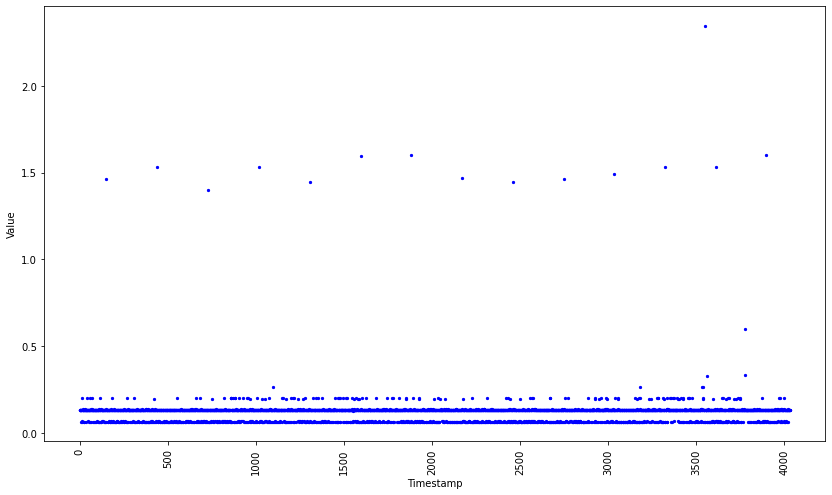

In [4]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(df.index, df['value'], color='blue', s=5)
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Timestamp', ylabel='Value')

In [5]:
#Label anomalies for further model performance evaluation

In [29]:
anomalies_timestamp = ["2014-02-26 22:05:00"]

In [30]:
df['is_anomaly'] = 1
for timestamp in anomalies_timestamp:
    df.loc[df['timestamp'] == timestamp, 'is_anomaly'] = -1
df.head()

,timestamp,value,is_anomaly
0,2014-02-14 14:30:00,0.132,1
1,2014-02-14 14:35:00,0.134,1
2,2014-02-14 14:40:00,0.134,1
3,2014-02-14 14:45:00,0.134,1
4,2014-02-14 14:50:00,0.134,1


In [31]:
df[df['is_anomaly']==-1]

,timestamp,value,is_anomaly
3547,2014-02-26 22:05:00,2.344,-1


In [32]:
df_inlier = df[df['is_anomaly'] == 1]
df_outlier = df[df['is_anomaly'] == -1]

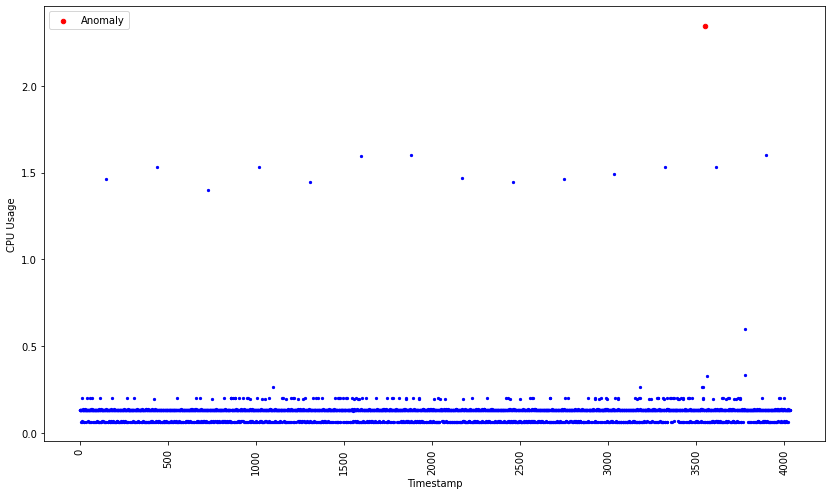

In [155]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(df_inlier.index, df_inlier['value'], color='blue', s=5)
ax.scatter(df_outlier.index, df_outlier['value'], color='red', s=20, label='Anomaly')
ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Timestamp', ylabel='CPU Usage')
ax.legend(loc=2)

In [11]:
#Split the dataset into train and test sets. The training set no to be polluted with outliers.
df_train = df[:3540]
df_test = df[3540:]

In [12]:
#train test with no outliers
X_train = df_train['value'].values.reshape(-1,1)
X_train

array([[0.132],
       [0.134],
       [0.134],
       ...,
       [0.2  ],
       [0.134],
       [0.066]])

In [13]:
#test set cointaining outliers
X_test = df_test['value'].values.reshape(-1,1)
X_test[1:10]

array([[0.132],
       [0.134],
       [0.066],
       [0.134],
       [0.132],
       [0.132],
       [2.344],
       [0.134],
       [0.066]])

### Local outlier factor (LOF)

**2.7. Novelty and Outlier Detection**
Many applications require being able to decide whether a new observation belongs to the same distribution as existing observations (it is an inlier), or should be considered as different (it is an outlier). Often, this ability is used to clean real data sets. Two important distinctions must be made:

**Outlier detection**:
The training data contains outliers which are defined as observations that are far from the others. Outlier detection estimators thus try to fit the regions where the training data is the most concentrated, ignoring the deviant observations.

**Novelty detection**:
The training data is not polluted by outliers and we are interested in detecting whether a new observation is an outlier. In this context an outlier is also called a novelty.

In [22]:
#The amount of contamination of the data set, i.e. the proportion of outliers in the data set
contamination = 1/len(df)
contamination

0.0020325203252032522

In [61]:
clf = LocalOutlierFactor(contamination=contamination, novelty=True, n_neighbors=25)
clf.fit(X_train)

LocalOutlierFactor(contamination=0.0020325203252032522, n_neighbors=25,
                   novelty=True)

In [62]:
y_pred = clf.predict(X_test)

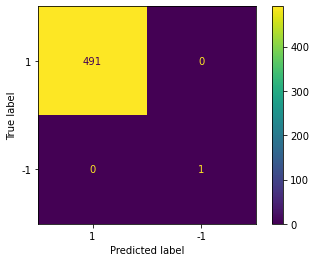

In [63]:
cm = confusion_matrix(df_test['is_anomaly'], y_pred, labels=[1, -1])
disp_cm = ConfusionMatrixDisplay(cm, display_labels=[1, -1])
disp_cm.plot();

In [148]:
#Investigating the optimal value for n_neighbours
accuracy_results=[]
precision_results=[]
recall_results=[]
f1_score_results=[]

for n in range(10,100,2):
    clf = LocalOutlierFactor(contamination=contamination, novelty=True, n_neighbors=n)
    clf.fit(X_train)
    y_pred = clf.predict(X_test)
    accuracy_results.append(accuracy_score(df_test['is_anomaly'], y_pred))
    precision_results.append(precision_score(df_test['is_anomaly'], y_pred))
    f1_score_results.append(f1_score(df_test['is_anomaly'], y_pred))
    recall_results.append(recall_score(df_test['is_anomaly'], y_pred))
    

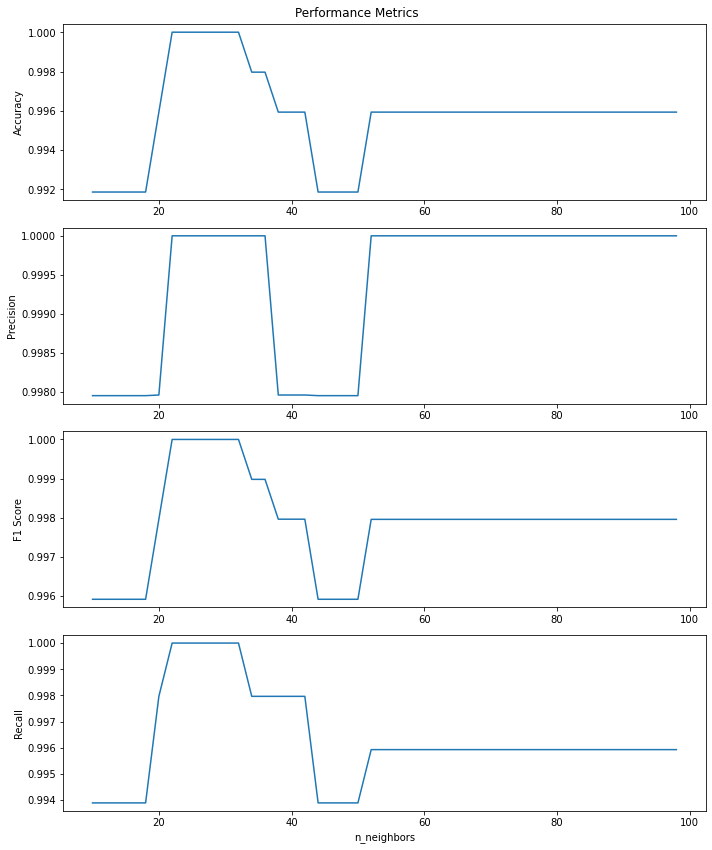

In [156]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))
fig.suptitle('Performance Metrics')

ax1.plot(list(range(10,100,2)), accuracy_results)
ax1.set_ylabel('Accuracy')

ax2.plot(list(range(10,100,2)), precision_results)
ax2.set_ylabel('Precision')

ax3.plot(list(range(10,100,2)), f1_score_results)
ax3.set_ylabel('F1 Score')

ax4.plot(list(range(10,100,2)), recall_results)
ax4.set_xlabel('n_neighbors')
ax4.set_ylabel('Recall')
plt.tight_layout()
plt.show()

Performance metrics for classification machine learning models are used to evaluate the performance and accuracy of the model's predictions. These metrics help in understanding how well the model is performing in classifying the data into different classes. 

Evaluating performance metrics for imbalanced models requires careful consideration and the use of appropriate metrics that can handle imbalanced datasets. In imbalanced datasets, one class may have significantly more samples than the other, leading to biased evaluations if standard metrics like accuracy are used.

**Some of the commonly used performance metrics:**

1. **Accuracy**: The ratio of correctly predicted instances to the total number of instances. It gives an overall measure of how well the model is performing.

2. **Precision**: The ratio of true positive (TP) predictions to the total number of positive predictions (TP + false positives (FP)). It measures the accuracy of positive predictions.

3. **Recall** (Sensitivity or True Positive Rate): The ratio of true positive (TP) predictions to the total number of actual positive instances (TP + false negatives (FN)). It measures the ability of the model to identify positive instances.

4. **F1 Score**: The harmonic mean of precision and recall. It provides a balance between precision and recall when dealing with imbalanced datasets.

5. **Specificity** (True Negative Rate): The ratio of true negative (TN) predictions to the total number of actual negative instances (TN + false positives (FP)). It measures the ability of the model to identify negative instances.

6. **Area Under the Receiver Operating Characteristic Curve (AUC-ROC)**: The area under the ROC curve, which represents the trade-off between true positive rate (recall) and false positive rate across different classification thresholds. It provides a measure of how well the model can distinguish between classes.

7. **Area Under the Precision-Recall Curve (AUC-PR)**: The area under the precision-recall curve, which measures the trade-off between precision and recall for different classification thresholds. It is particularly useful for imbalanced datasets.

8. **Confusion Matrix**: A matrix that summarizes the model's predictions compared to the actual labels. It includes true positive (TP), true negative (TN), false positive (FP), and false negative (FN) counts.

The choice of performance metric depends on the problem, the class distribution, and the specific requirements of the application. For instance, in cases of imbalanced datasets, metrics like F1 score and AUC-PR are more informative than accuracy. It is essential to consider multiple metrics to get a comprehensive understanding of the model's performance.